# Taming Transformers

This notebook is a minimal working example to generate landscape images as in [Taming Transformers for High-Resolution Image Synthesis](https://github.com/CompVis/taming-transformers). **tl;dr** We combine the efficiancy of convolutional approaches with the expressivity of transformers by introducing a convolutional VQGAN, which learns a codebook of context-rich visual parts, whose composition is modeled with an autoregressive transformer.

## Setup
The setup code in this section was written to be [run in a Colab environment](https://colab.research.google.com/github/CompVis/taming-transformers/blob/master/scripts/taming-transformers.ipynb). For a full, local setup, we recommend the provided [conda environment](https://github.com/CompVis/taming-transformers/blob/master/environment.yaml), as [described in the readme](https://github.com/CompVis/taming-transformers#requirements). This will also allow you to run a streamlit based demo.

Here, we first clone the repository and download a model checkpoint and config.

In [ ]:
!mkdir -p logs/2020-11-09T13-31-51_sflckr/checkpoints
!wget 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' -O 'logs/2020-11-09T13-31-51_sflckr/checkpoints/last.ckpt'
!mkdir logs/2020-11-09T13-31-51_sflckr/configs
!wget 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' -O 'logs/2020-11-09T13-31-51_sflckr/configs/2020-11-09T13-31-51-project.yaml'

: 

Next, we install minimal required dependencies.

In [ ]:
%pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops transformers
import sys
sys.path.append(".")

## Loading the model

We load and print the config.

In [ ]:
from omegaconf import OmegaConf
config_path = "logs/2020-11-09T13-31-51_sflckr/configs/2020-11-09T13-31-51-project.yaml"
config = OmegaConf.load(config_path)
import yaml
print(yaml.dump(OmegaConf.to_container(config)))

data:
  params:
    batch_size: 1
    validation:
      target: taming.data.sflckr.Examples
  target: main.DataModuleFromConfig
model:
  base_learning_rate: 4.5e-06
  params:
    cond_stage_config:
      params:
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          double_z: false
          dropout: 0.0
          in_channels: 182
          num_res_blocks: 2
          out_ch: 182
          resolution: 256
          z_channels: 256
        embed_dim: 256
        image_key: segmentation
        lossconfig:
          target: taming.modules.losses.DummyLoss
        n_embed: 1024
      target: taming.models.vqgan.VQModel
    cond_stage_key: segmentation
    first_stage_config:
      params:
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          doub

Instantiate the model.

In [ ]:
from taming.models.cond_transformer import Net2NetTransformer
model = Net2NetTransformer(**config.model.params)
# print(model)
# model:
#   - first stage model:
#     - encoder(down sample)
#     - decoder(up sample)
#     - quantize(VQ)
#     - quant_conv
#     - post_quant_conv
#   - cond stage model:
#     - encoder(down sample)
#     - decoder(up sample)
#     - quantize(VQ)
#     - quant_conv
#     - post_quant_conv
#   - transformer
#   - head

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Load the checkpoint.

In [ ]:
import torch
ckpt_path = "logs/2020-11-09T13-31-51_sflckr/checkpoints/last.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False) # load weight

In [ ]:
model.cuda().eval()
torch.set_grad_enabled(False)

## Load example data

Load an example segmentation and visualize.

In [ ]:
from PIL import Image
import numpy as np
segmentation_path = "data/sflckr_segmentations/norway/25735082181_999927fe5a_b.png" # segmentation image
segmentation = Image.open(segmentation_path)
segmentation = np.array(segmentation)
segmentation = np.eye(182)[segmentation]
segmentation = torch.tensor(segmentation.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)
print(segmentation.shape) # resolution (683, 1024), segmentation channels: 182

torch.Size([1, 182, 683, 1024])


Visualize

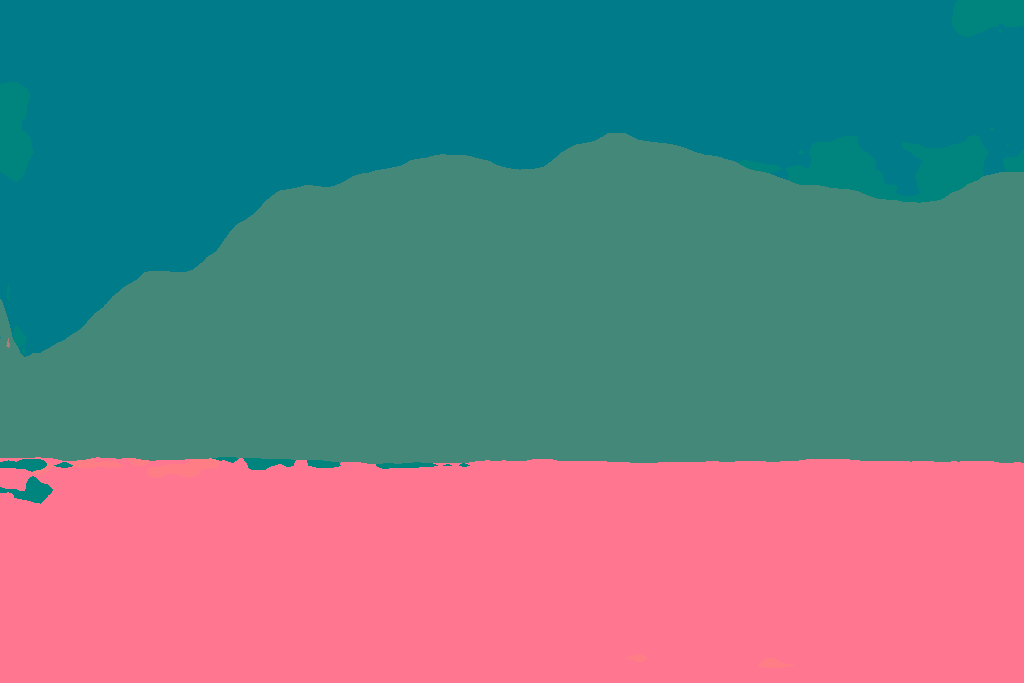

In [ ]:
def show_segmentation(s):
  s = s.detach().cpu().numpy().transpose(0,2,3,1)[0,:,:,None,:]
  colorize = np.random.RandomState(1).randn(1,1,s.shape[-1],3)
  colorize = colorize / colorize.sum(axis=2, keepdims=True)
  s = s@colorize
  s = s[...,0,:]
  s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
  s = Image.fromarray(s)
  display(s)

show_segmentation(segmentation)

Our model also employs a VQGAN for the conditioning information, i.e. the segmentation in this example. Let's autoencode the segmentation map. Encoding returns both the quantized code and its representation in terms of indices of a learned codebook.

c_code torch.Size([1, 256, 42, 64]) torch.float32
c_indices torch.Size([2688]) torch.int64


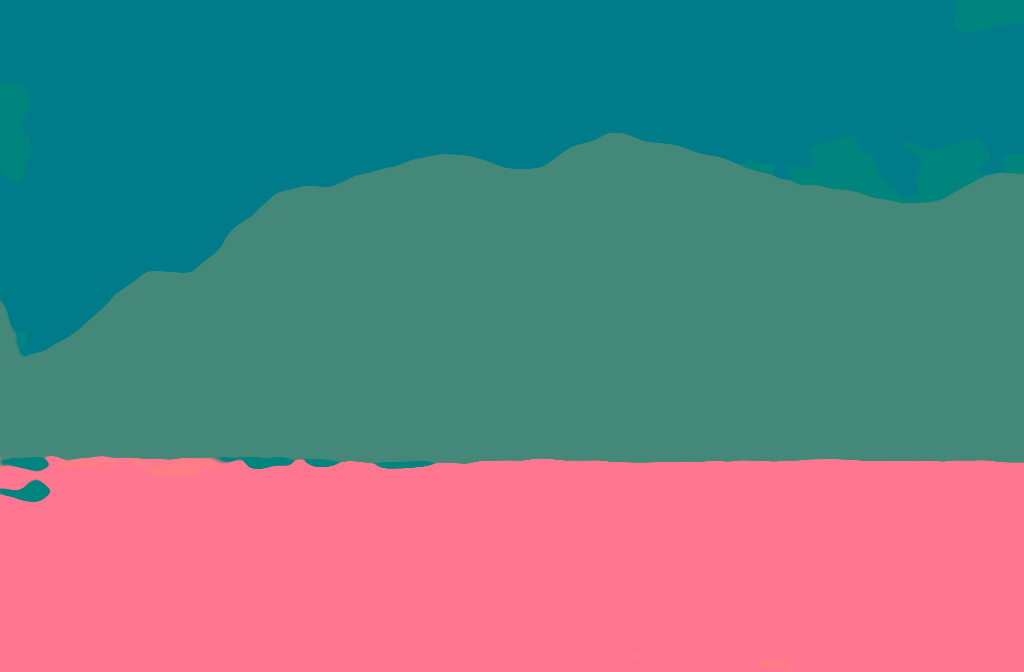

In [ ]:
c_code, c_indices = model.encode_to_c(segmentation) # segmentation is a segmentation image: (batch, channels, height, weight)
# encode_to_c call cond_stage_model.encode(), image => latent representation (after vq)
print("c_code", c_code.shape, c_code.dtype)   # c_code is the quantize vector, (zq: batch, embed_dim, h, w)
print("c_indices", c_indices.shape, c_indices.dtype)  # c_indices is min_encoding_indices, (n)  # n = h * w * batch
assert c_code.shape[2]*c_code.shape[3] == c_indices.shape[0]
segmentation_rec = model.cond_stage_model.decode(c_code)  # decode: z_channels => out_channels (z_channels is same with embed_dim) 256
show_segmentation(torch.softmax(segmentation_rec, dim=1))

Let's sample indices corresponding to codes from the image VQGAN given the segmentation code. We init randomly and take a look.

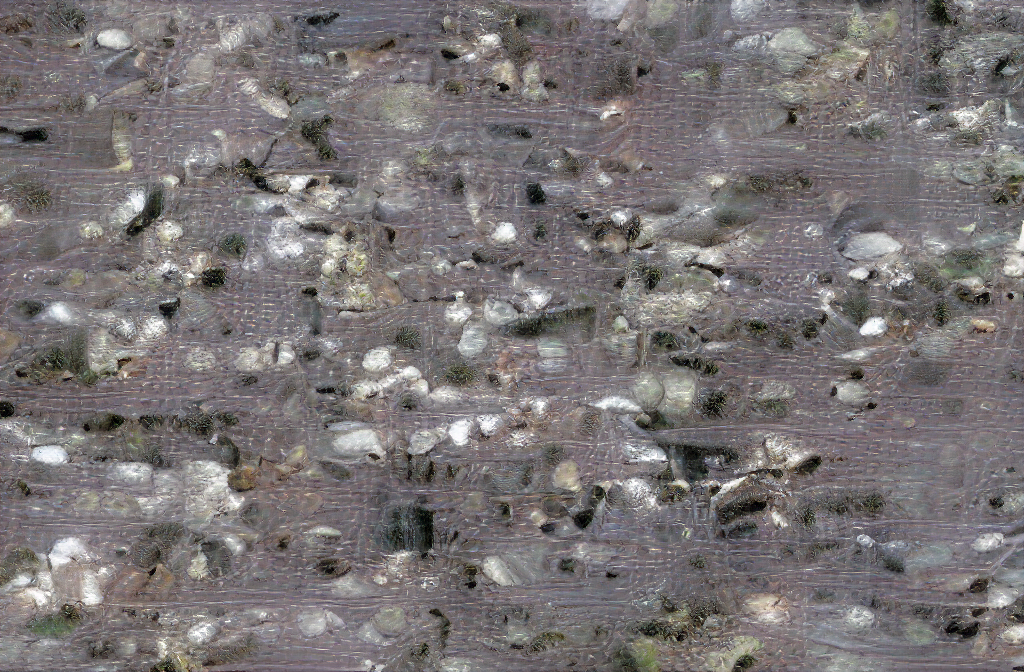

In [ ]:
def show_image(s):
  s = s.detach().cpu().numpy().transpose(0,2,3,1)[0]
  s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
  s = Image.fromarray(s)
  display(s)

# codebook_size = config.model.params.first_stage_config.params.embed_dim # embed_dim? 256, vocab_size = n_embed
codebook_size = config.model.params.first_stage_config.params.n_embed # n_embed: 1024
z_indices_shape = c_indices.shape # (h*w, )
z_code_shape = c_code.shape # (batch, embed_dim, h, w)
z_indices = torch.randint(codebook_size, z_indices_shape, device=model.device)  # random indices
x_sample = model.decode_to_img(z_indices, z_code_shape)
show_image(x_sample)

## Sample an image

We use the transformer in a sliding window manner to sample all code entries sequentially. The code below assumes a window size of $16\times 16$.

Time: 377.30203127861023 seconds
Step: (41,63) | Local: (15,15) | Crop: (26:42,48:64)


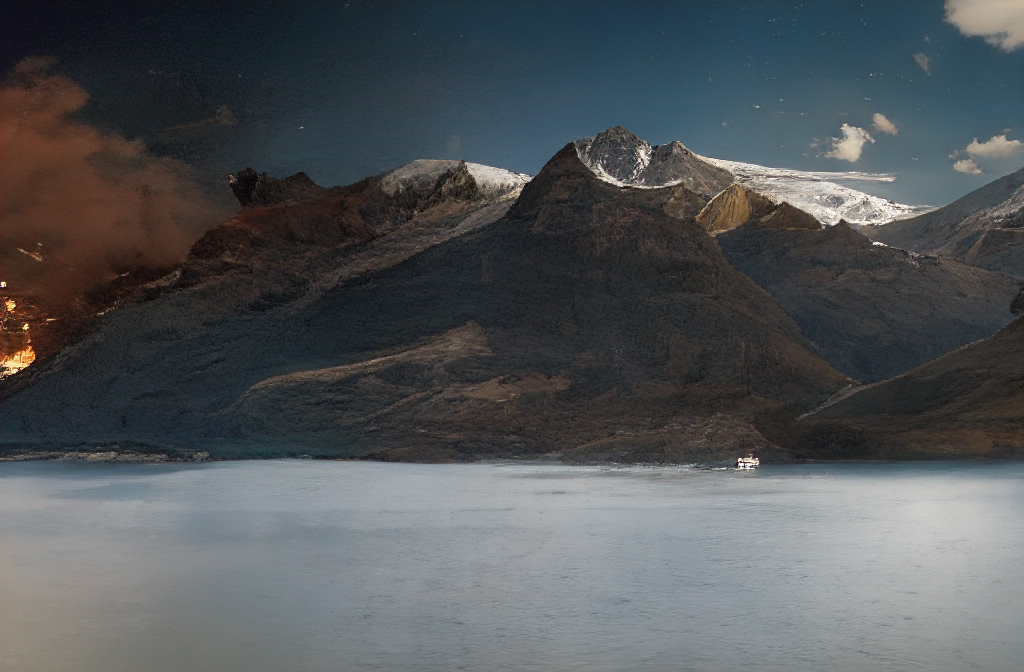

In [ ]:
from IPython.display import clear_output
import time

idx = z_indices
idx = idx.reshape(z_code_shape[0],z_code_shape[2],z_code_shape[3])  # (batch, h, w): 1d => 2d

cidx = c_indices
cidx = cidx.reshape(c_code.shape[0],c_code.shape[2],c_code.shape[3])  # (batch, h, w): 1d => 2d

temperature = 1.0
top_k = 100
update_every = 50

start_t = time.time()
for i in range(0, z_code_shape[2]-0): # loop for row
  # left boundary
  if i <= 8:
    local_i = i
  # right boundary
  elif z_code_shape[2]-i < 8:
    local_i = 16-(z_code_shape[2]-i)
  # mid
  else:
    local_i = 8 # center of the patch
  for j in range(0,z_code_shape[3]-0):  # loop for col
    if j <= 8:
      local_j = j
    elif z_code_shape[3]-j < 8:
      local_j = 16-(z_code_shape[3]-j)
    else:
      local_j = 8

    i_start = i-local_i
    i_end = i_start+16  # patch size 16? 16 pixels? no, 16 indices, use a patch to predict next token
    j_start = j-local_j
    j_end = j_start+16

    # left-up: 16 * 16
    patch = idx[:,i_start:i_end,j_start:j_end]  # idx: (batch, h, w), 2d indices, and idx is a random codebook indices
    patch = patch.reshape(patch.shape[0],-1)  # patch: (batch, patch_h, patch_w) => (batch, patch_hw)
    # print(f"patch.shape: {patch.shape}")  # patch.shape: torch.Size([1, 256])
    cpatch = cidx[:, i_start:i_end, j_start:j_end]  # cidx: (batch, h, w), 2d indices, and cidx is a segmentation codebook indices
    cpatch = cpatch.reshape(cpatch.shape[0], -1)  # cpatch: (batch, patch_h, patch_w) => (batch, patch_hw)
    # print(f"cpatch.shape: {cpatch.shape}")  # cpatch.shape: torch.Size([1, 256])
    # patch and cpatch: (batch(1), patch_hw(16*16=256))
    patch = torch.cat((cpatch, patch), dim=1) # final patch indices: (batch, 2 * patch_hw) (1, 512), cpatch is in the front of patch
    # print(f"patch.shape after concat: {patch.shape}") # patch.shape after concat: torch.Size([1, 512])
    # print(f"transformer input.shape: {patch[:, :-1].shape}")  # transformer input.shape: torch.Size([1, 511])
    logits,_ = model.transformer(patch[:,:-1])  # predict next token (codebook index), (batch, patch_hw - 1, vocab_size)
    # print(f"transformer output.shape: {logits.shape}")  # transformer output.shape: torch.Size([1, 511, 1024])
    logits = logits[:, -256:, :]  # the last index in the segmentation indices (different with image indices) (batch, 1, vocab_size)
    logits = logits.reshape(z_code_shape[0],16,16,-1)
    # print(f"reshape logits.shape: {logits.shape}")    # reshape logits.shape: torch.Size([1, 16, 16, 1024])
    logits = logits[:,local_i,local_j,:]
    # the first image token is the prediction result of the last segmentation token, while the prediction result of the last token is not required
    logits = logits/temperature
    # The first image token is the prediction of the last segmentation token, and the prediction of the last token is not needed
    # So the transformer's input can be 512 dimensional indices.
    # However, the predict result should be selected starting from the last token prediction of the segmentation.
    if top_k is not None:
      logits = model.top_k_logits(logits, top_k)

    probs = torch.nn.functional.softmax(logits, dim=-1)
    idx[:,i,j] = torch.multinomial(probs, num_samples=1)  # update idx, to decode an image

    step = i*z_code_shape[3]+j
    if step%update_every==0 or step==z_code_shape[2]*z_code_shape[3]-1:
      x_sample = model.decode_to_img(idx, z_code_shape) # decode_to_image, input index and shape
      clear_output()
      print(f"Time: {time.time() - start_t} seconds")
      print(f"Step: ({i},{j}) | Local: ({local_i},{local_j}) | Crop: ({i_start}:{i_end},{j_start}:{j_end})")
      show_image(x_sample)